# IML Take-Home Assignment 2

### Students: 
* MARTINEZ ZAMUDIO Andrey
* THAPA Prabhat
* PEREIRA DE MAGALHAES David

### Group: 20

## A. Multi-Armed Bandits (10 points)

### Problem 1
> Consider an agent performing a sequence of actions $a(i)$ and receiving a sequence of rewards $r(i).$ Suppose the agent can observe the reward of its last step before performing the next action.
>
> So far, we've described a wide range of decision processes. Describe an additional simplifying assumption that holds for any **multi-armed bandit problem**. _(2 points)_

In multi-armed bandit problems, it is often assumed that each arm´s reward distribution stays the same over time. 
This means the rewards follow a fixed pattern, which allows the agent to learn each arm´s behaviour without worrying about the changes over time.

### Problem 2

> Consider a multi-armed bandit problem of the form defined by `Policy.evaluate` below, where the reward of each arm is Bernoulli distributed.

In [2]:
from numpy.typing import NDArray
from typing import List
import numpy as np
import pandas as pd


class Policy:
    def choose_arm(self, n_arms: int, arms: NDArray, rewards: NDArray) -> int:
        """
        arms[i]: arm chosen at iteration i
        rewards[i]: reward we got at iteration i
        """

        raise NotImplementedError()

    def evaluate(self, arm_values: List[float], n_iters=1000):
        n_arms = len(arm_values)
        arms = np.zeros(n_iters, dtype=np.int8)
        rewards = np.zeros(n_iters, dtype=np.int8)

        for i in range(n_iters):
            arm = self.choose_arm(n_arms, arms, rewards)
            reward = np.random.random() <= arm_values[arm]
            arms[i] = arm
            rewards[i] = reward

        df = pd.DataFrame(
            {
                "arms": arms,
                "rewards": rewards,
            },
            index=pd.Index(np.arange(n_iters), name="iteration"),
        )
        return df


class RandomPolicy(Policy):
    def choose_arm(self, n_arms, arms, rewards) -> int:
        return np.random.choice(n_arms)

> Now consider the policy `RandomPolicy`, which chooses a random arm at each iteration. What can you say about the average reward
> $$
R_T = \frac 1 T \sum_{i = 1}^T r(i)
$$
> that this policy will obtain over an episode with a very large number $T$ of iterations? Make a prediction for the case `arm_values=[0.1, 0.1, 0.1, 0.6]` and check it with an experiment. _(2 points)_

For a random policy, each arm is selected with equal probability, so the expected reward over time will approach the average of the reward probabilities for all arms. 
Given the arm_values as above, the average reward will be= (0.1+0.1+0.1+0.6)/4 which euqals to 0.225

In [3]:
arm_values = [0.1, 0.1, 0.1, 0.6]
policy = RandomPolicy()
df = policy.evaluate(arm_values, n_iters=10000)

average = df['rewards'].mean()
print(f"Average after 10,000 its: {average}")

Average after 10,000 its: 0.2231


### Problem 3

> Implement the $\epsilon$-greedy strategy. Let `arm_values=[0.1, 0.1, 0.1, 0.6]` and $\epsilon = 0.2,$ and graph the cumulative mean reward over the course of one episode. _(2 points)_

In [4]:
from dataclasses import dataclass


@dataclass
class EpsilonGreedy(Policy):
    epsilon: float

    def choose_arm(self, n_arms, arms, rewards):
        if np.random.random() < self.epsilon:
            return np.random.choice(n_arms)
        else:
            avg_rewards = [np.mean(rewards[arms == i]) if i in arms else 0 for i in range(n_arms)]
            return int(np.argmax(avg_rewards))


e_greedy_policy = EpsilonGreedy(epsilon=0.2)
df = e_greedy_policy.evaluate([0.1, 0.1, 0.1, 0.6])


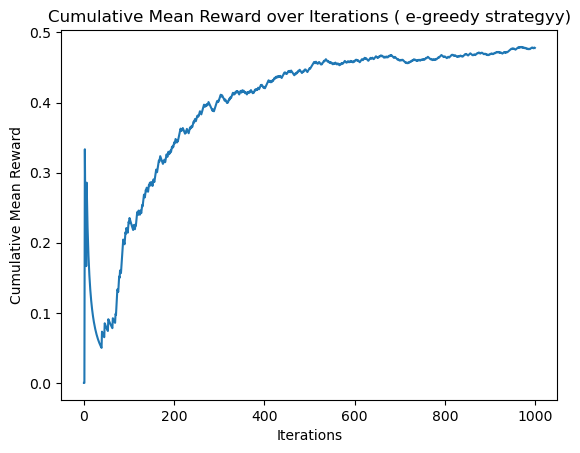

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x=df.index, y=df["rewards"].expanding().mean())
plt.xlabel("Iterations")
plt.ylabel("Cumulative Mean Reward")
plt.title("Cumulative Mean Reward over Iterations ( e-greedy strategyy)")
plt.show()

### Problem 4

> Our _regret_ at iteration $T$ is the difference
> $$
\rho_T = T V - \sum_{i = 1}^T r(i)
$$
> between the expected reward of $T$ draws from the arm with maximum expected reward $V$ and our empirical reward.
>
> Consider the behavior of $\rho_T$ under an $\epsilon$-greedy strategy for large $T.$ Predict the limit of $\rho_T/T$ for large $T$ as a function of $\epsilon$. Do some experiments and make a graph to validate your prediction. _(2 points)_

As T goes to infinity, the expected regret per step becomes proportional to the e-gredy strategy. 
This happens because, with probability e-greeedy, the agent picks a random arm, which is likely to give a lower reward than the best arm.
Over time, the regret greows linearly with e-greedy.

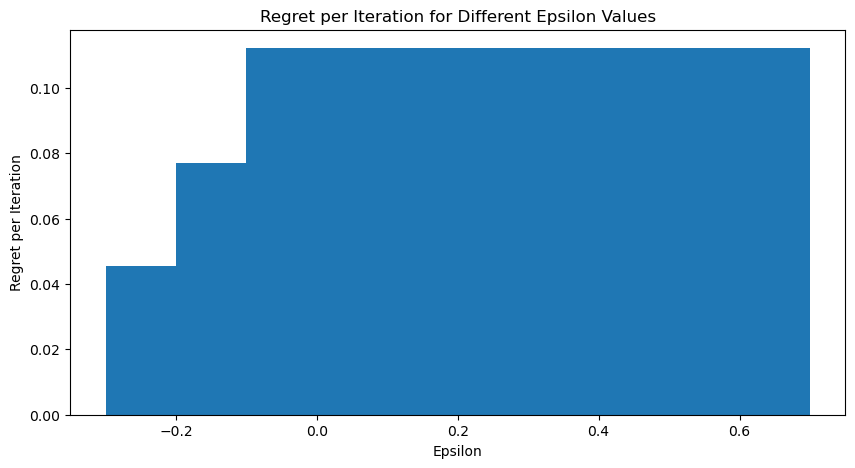

In [6]:
epsilon_values = [0.1, 0.2, 0.3]
arm_values = [0.1, 0.1, 0.1, 0.6]
n_iters = 10000
results = {}

for epsilon in epsilon_values:
    policy = EpsilonGreedy(epsilon=epsilon)
    df = policy.evaluate(arm_values, n_iters)
    
    optimal_reward = max(arm_values) * n_iters
    actual_reward = df["rewards"].sum()
    regret = optimal_reward - actual_reward
    regret_per_iteration = regret / n_iters
    results[epsilon] = regret_per_iteration

# Plotting regret per iteration for each epsilon value
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values())
plt.xlabel("Epsilon")
plt.ylabel("Regret per Iteration")
plt.title("Regret per Iteration for Different Epsilon Values")
plt.show()


### Problem 5

> A policy is called _zero-regret_ if $\rho_T/T$ converges to $0$ for large $T$.
>
> Suppose you have the prior knowledge that only one arm ever gives non-zero rewards. Design a policy that is zero-regret under this assumption. Check experimentally that it is. _(2 points)_

It works by sampling each arm once, identifying the rewarding arm, and sticking with it.

<Axes: xlabel='iteration', ylabel='rewards'>

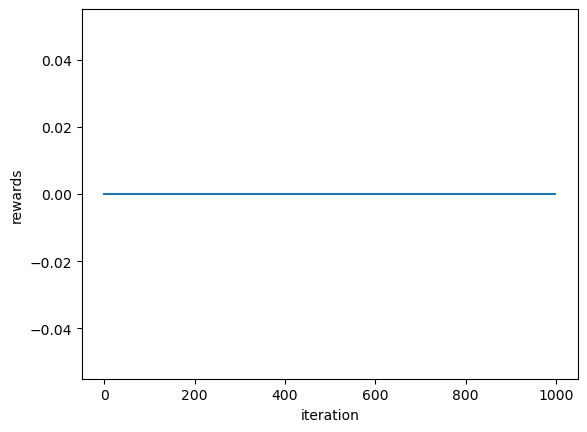

In [12]:
class SimpleZeroRegretPolicy(Policy):
    def choose_arm(self, n_arms, arms, rewards):
        if len(arms[arms == -1]) < n_arms:
            return len(arms[arms == -1])
        return np.argmax([np.sum(rewards[arms == arm]) for arm in range(n_arms)])

policy = SimpleZeroRegretPolicy()
df = policy.evaluate([0, 0.5, 0, 0])
sns.lineplot(data=df["rewards"].expanding().mean())


### Problem 6 (bonus)

> Now suppose that all arms except one give Bernoulli distributed rewards with mean $0.4$, and the remaining arm gives Bernoulli distributed rewards with mean $0.6.$ Implement a Thompson sampling policy adapted to this prior knowledge. Plot the regret $\rho_T$ over a few episodes. _(2 points)_

In [8]:
class ThompsonPolicy(Policy):
    def choose_arm(self, n_arms, arms, rewards):
        raise NotImplementedError()  # Your code here


# ThompsonPolicy().evaluate([0.4, 0.6, 0.4, 0.4])

## B. Reinforcement Learning (10 points)

The following class defines a kind of gridworld environment that we'll use for reinforcement learning.

In [92]:
from typing import Optional
import numpy as np


class Dungeon:
    def __init__(self, s: str, p_slippery=0.5):
        self.tile_mat = self._read_dungeon(s)
        self.h, self.w = self.tile_mat.shape
        self.n_states = self.h * self.w
        self.tiles = self.tile_mat.flatten()
        self.p_slippery = p_slippery

        self.start = self.tile_indices("s")[0]
        self.end = self.tile_indices("e")[0]
        self.transitions = self._build_transitions()
        self.rewards = -np.ones_like(self.tiles, dtype=float)

    def tile_indices(self, char: str) -> np.ndarray:
        return np.where(self.tiles == char)[0]

    def _read_dungeon(self, s: str) -> np.ndarray:
        lines = s.strip().split("\n")
        max_len = max(len(line) for line in lines)
        return np.array([list(line.ljust(max_len)) for line in lines])

    def _evaluate_action(self, action: np.ndarray, pos: np.ndarray) -> np.ndarray:
        b, _ = pos.shape  # (b, 2)
        start_pos = np.array([x[0] for x in np.where(self.tile_mat == "s")])

        directions = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
        pos_ = pos + directions[action]  # Move
        pos_ = np.maximum(pos_, 0)  # Clip to bounds
        pos_ = np.minimum(pos_, np.array([self.h - 1, self.w - 1]))
        square_ = self.tile_mat[pos_[:, 0], pos_[:, 1], None]
        pos_ = np.where(square_ == "#", pos, pos_)  # Don't move into walls
        pos_ = np.where(square_ == "O", start_pos, pos_)  # Holes teleport to start
        return pos_  # (b, 2)

    def _build_transitions(self) -> np.ndarray:
        action, y, x = [arr.flatten() for arr in np.mgrid[0:4, 0 : self.h, 0 : self.w]]
        y_, x_ = self._evaluate_action(action, np.stack([y, x], axis=-1)).T
        transitions = np.eye(self.n_states)[
            np.ravel_multi_index((y_, x_), (self.h, self.w))
        ]
        transitions = transitions.reshape((4, self.h * self.w, self.h * self.w))
        action_transfer = (self.p_slippery / 4) * np.ones((4, 4)) + (
            1 - self.p_slippery
        ) * np.eye(4)
        return np.tensordot(action_transfer, transitions, axes=(1, 0))

    def show(self, vect: Optional[np.ndarray] = None, size=0.5, values=True):
        import matplotlib.pyplot as plt
        from matplotlib.patches import Rectangle
        from matplotlib.colors import Normalize

        fig, ax = plt.subplots()
        plt.tight_layout()
        ax.set_xlim(-0.5, self.w - 0.5)
        ax.set_ylim(self.h - 0.5, -0.5)
        fig.set_size_inches(self.w * size, self.h * size)
        ax.set_aspect(1)
        ax.set_axis_off()

        cmap = plt.get_cmap("Blues")
        if vect is not None and vect.dtype.type != np.str_:
            norm = Normalize(vect.min(), vect.max())

        y, x = [x.flatten() for x in np.mgrid[0 : self.h, 0 : self.w]]
        chars = self.tile_mat[y, x].flatten()
        for i in range(self.n_states):
            text_opts = lambda style: {
                "color": "black",
                "ha": "center",
                "va": "center",
                "fontweight": style,
            }
            pos = lambda offset: (x[i], y[i] + offset)
            ax.text(*pos(0.2), chars[i], **text_opts("bold"))  # pyright: ignore

            rect_opts = {"facecolor": "white", "edgecolor": "grey"}
            if vect is not None and vect.dtype.type != np.str_:
                d = vect[i]
                rect_opts["facecolor"] = cmap(norm(vect[i]) * 0.8)  # pyright: ignore
            ax.add_patch(Rectangle((x[i] - 0.5, y[i] - 0.5), 1, 1, **rect_opts))  # pyright: ignore

            if values and vect is not None:
                if vect.dtype.type == np.str_:
                    text = vect[i]
                else:
                    text = f"{vect[i]:.2f}"
                ax.text(*pos(-0.2), text, **text_opts("regular"))  # pyright: ignore

Characters in the dungeon have the following meanings.

- `s`: our starting position
- `e`: the exit of the dungeon
- `#`: impassable walls
- `O`: holes that teleport us back to the start

Our goal is to get from the start to the end as quickly as possible. At each iteration, we can choose to move up, down, left or right. However, the dungeon floor is slippery, so with some probability `p_slippery` we'll move in a random direction instead.

`simple_dungeon()` makes a small dungeon with some holes in the center.

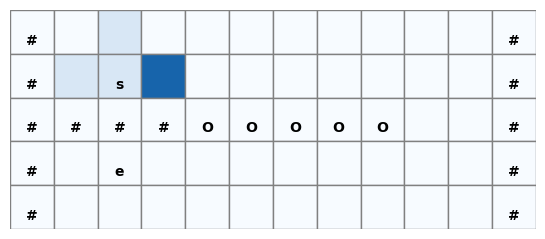

In [93]:
def simple_dungeon(**kwargs):
    return Dungeon(
        """
#          #
# s        #
####OOOOO  #
# e        #
#          #
""",
        **kwargs,
    )


dungeon = simple_dungeon()
# Show distribution over states conditional on the "right" action
dungeon.show(dungeon.transitions[2, dungeon.start], values=False)

### Problem 1
> `dungeon.transitions[action, state, next_state]` gives the probability that `action` will move us from `state` to `next_state`. Suppose we start at the initial state and perform the actions `[0, 2, 2]` in sequence. Compute our resulting probability distribution over states and display it using `Dungeon.show()`. _(2 points)_

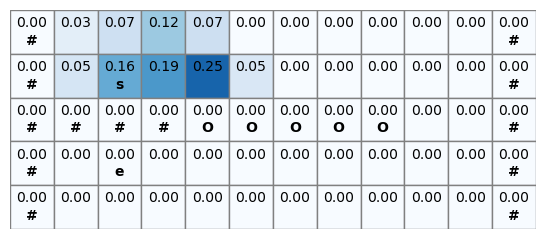

In [94]:
state_prob_distribution = np.zeros(dungeon.n_states) # Initialize the dungeon matrix with all zeros
state_prob_distribution[dungeon.start] = 1.0 # Initialize the start position probability to 1

actions = [0,2,2] # Sequence of actions (down, right, right)

# loop through the actions sequence 
for action in actions:
    # compute the matrix-vector multiplication with the @ operator to update the probability distribution for action in actions
    state_prob_distribution = state_prob_distribution @ dungeon.transitions[action]

dungeon.show(state_prob_distribution)

### Problem 2

> Let $V(s)$ denote the expected number of steps that it would take the optimal policy to get from state $s$ to the terminal state.
>
> Write down Bellman optimality conditions for these "state values" $V(s).$ Using value iteration, write a function to compute them. Display the state values of `simple_dungeon(p_slippery=0.5)` using `Dungeon.show()`. (Set the value of inaccessible states occupied by walls and holes to 0.)

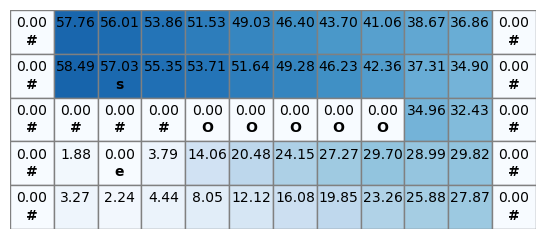

In [95]:
def compute_values(dungeon: Dungeon) -> np.ndarray:
    values = np.zeros(dungeon.n_states)

    # Your code here
    threshold = 1e-8  # Convergence stop criteria once the value changes are minimal (< 0.00000001)

    while True:
        # max change at each iteration
        delta = 0

        new_values = values.copy()

        # iterate over each state
        for state in range(dungeon.n_states):

            # set tiles with walls and holes to 0
            if dungeon.tiles[state] in ['#', 'O']:
                new_values[state] = 0  
                continue

            # set exit tile to 0
            if state == dungeon.end:
                new_values[state] = 0  # Terminal state has value 0
                continue

            # Update the values with the Bellman optimality
            action_values = []
            for a in range(4):
                next_state_values = dungeon.transitions[a, state] @ (1 + values)
                action_values.append(next_state_values)

            # put the Bellman Optimality value in the new_values variable
            new_values[state] = min(action_values)
            # compute the maximum difference
            delta = max(delta, abs(new_values[state] - values[state]))

        # put the new_values in the values
        values = new_values

        # break the while loop if the maximum delta is smaller than the predefined threshold
        if delta < threshold:
            break

    return values

dungeon = simple_dungeon(p_slippery=0.5)
state_values = compute_values(dungeon)
dungeon.show(state_values, values=True)


#### Bellman optimality Conditions for these "state values" $V(s)$:

$
V(s) = \min_{a} \sum_{s'} P(s'|s, a) \left[R(s, a, s') + \gamma V(s')\right]
$

- $ V(s) $: optimal value of state
- $ P(s'|s, a) $: probability of transitioning from state $s$ to state $s'$ with action $a$
- $ R(s, a, s') $: reward received when, -1 for a penalty
- $ V(s') $: value of the next state $s'$
- $ \gamma $ discount factor (1 in our case)

### Problem 3
> Explain how we can compute an optimal policy using the transition probabilities and the state values $V(s).$ Compute an optimal policy for `simple_dungeon(p_slippery=0.5)` and show it. _(2 points)_

#### Optimal Policy
Optimal policy $\pi$ represents the best action to take in each state in order to reach the end with the least steps possible.

It can be computed by choosing the action $a$ that goes to the state $s'$ with the lowest value of the following computation:

$
\pi(s) = argmin_{a} \sum_{s'} P(s'|s,a) [R(s,a,s') + V(s')]
$

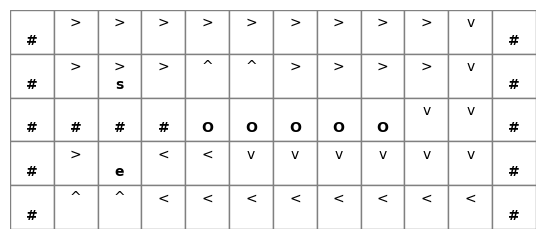

In [96]:
def compute_actions(dungeon: Dungeon, values: np.ndarray) -> np.ndarray:
    actions = np.repeat(0, dungeon.n_states) 
    
    # Your code here

    # loop through the states
    for state in range(dungeon.n_states):
        # skip the walls and the holes
        if dungeon.tiles[state] in ['#','O']:
            continue

        # Compute the values with the formula from above (argmin instead of min)
        action_values = []
        for a in range(4):
            next_state_values = dungeon.transitions[a, state] @ (1 + values)
            action_values.append(next_state_values)

        actions[state] = np.argmin(action_values)

    # Convert action codes to ASCII
    chars = np.array(["v", "^", ">", "<"])[actions]
    chars[np.isin(dungeon.tiles, np.array(["#", "O", "e"]))] = " "
    return chars


dungeon = simple_dungeon(p_slippery=0.5)
state_values = compute_values(dungeon)
best_actions = compute_actions(dungeon, state_values)
dungeon.show(best_actions)

#### Conclusion

With the 2 previous dungeons displays, we can see that the path choosen lues computed in problem 2, thus the arrows make a path to the end and choose the tile with the lowest value.

### Problem 4
> Write an agent that learns to complete the dungeon using Q-learning.
>
> "Reward" the agent with a value of $-1$ at each step and do not use exponential discounting, so that negative total reward equals the number of steps taken to complete the dungeon. Plot the reward over $500$ episodes of training on `simple_dungeon(p_slippery=0.2)`. Finally, disable exploration and report the average number of steps your agent takes over 100 episodes. This should be close to the optimal value you computed above. (The parameters of the Q-learning algorithm are up to you.) _(4 points)_

In [97]:
class DungeonAgent:
    def __init__(self, n_states, epsilon=0.2, update=0.1):
        self.q_values = np.zeros((4, n_states))
        self.epsilon = epsilon
        self.update = update
        self.visited = np.zeros(n_states, dtype=np.int32)

    def choose_action(self, state: int) -> int:
        return 0  # Your code here

    # Stuff missing here??

    def run_episode(self, dungeon: Dungeon, max_iter=1000):
        states = np.zeros(max_iter, dtype=np.int16)
        states[0] = dungeon.start

        step = 0
        for step in range(max_iter - 1):
            state = states[step]
            action = self.choose_action(state)
            next_state = np.random.choice(
                dungeon.h * dungeon.w, p=dungeon.transitions[action, state]
            )
            states[step + 1] = next_state

            # Stuff missing here??

        return states[: step + 1]

In [98]:
from tqdm import tqdm
import seaborn as sns

dungeon = simple_dungeon(p_slippery=0.2)
agent = DungeonAgent(dungeon.n_states)


def train_agent(agent: DungeonAgent, dungeon: Dungeon, episodes):
    steps = np.zeros(episodes)
    for i in tqdm(range(episodes)):
        steps[i] = agent.run_episode(dungeon).shape[0]
    return steps


# Your code here
# sns.lineplot(-train_agent(agent, dungeon, episodes=500))

### Problem 5 (bonus)
> Do Exercise 4.9 from page 106 of Sutton's _Introduction to Reinforcement Learning_, available at <http://incompleteideas.net/book/RLbook2020.pdf>. _(2 points)_